# Problem Setting: Representation Learning.

This notebook demonstrates that the Energy-based Adversarial-Auto-Encoder(EBAAE) can learn images and reconstruct its. Image dataset for this demo is the [Weizmann horse dataset](https://avaminzhang.wordpress.com/2012/12/07/%E3%80%90dataset%E3%80%91weizmann-horses/). The code of this notebook is written on the premise that the MNIST images are divided and arranged in directories for each label beforehand.

## Problem Solution: Energy-based Adversarial Auto-Encoder(EBAAE).

The Generative Adversarial Networks(GANs) (Goodfellow et al., 2014) framework establishes a min-max adversarial game between two neural networks – a generative model, `G`, and a discriminative model, `D`. The discriminator model, `D(x)`, is a neural network that computes the probability that a observed data point `x` in data space is a sample from the data distribution (positive samples) that we are trying to model, rather than a sample from our generative model (negative samples). 

Concurrently, the generator uses a function `G(z)` that maps samples `z` from the prior `p(z)` to the data space. `G(z)` is trained to maximally confuse the discriminator into believing that samples it generates come from the data distribution. The generator is trained by leveraging the gradient of `D(x)` w.r.t. x, and using that to modify its parameters.

### Conditional GANs (or cGANs).

The Conditional GANs (or cGANs) is a simple extension of the basic GAN model which allows the model to condition on external information. This makes it possible to engage the learned generative model in different "modes" by providing it with different contextual information (Gauthier, J. 2014).

This model can be constructed by simply feeding the data, `y`, to condition on to both the generator and discriminator. In an unconditioned generative model, because the maps samples `z` from the prior `p(z)` are drawn from uniform or normal distribution, there is no control on modes of the data being generated. On the other hand, it is possible to direct the data generation process by conditioning the model on additional information (Mirza, M., & Osindero, S. 2014).

### Adversarial Auto-Encoders(AAEs)

This library also provides the Adversarial Auto-Encoders(AAEs), which is a probabilistic Auto-Encoder that uses GANs to perform variational inference by matching the aggregated posterior of the feature points in hidden layer of the Auto-Encoder with an arbitrary prior distribution(Makhzani, A., et al., 2015). Matching the aggregated posterior to the prior ensures that generating from any part of prior space results in meaningful samples. As a result, the decoder of the Adversarial Auto-Encoder learns a deep generative model that maps the imposed prior to the data distribution.

### Energy-based GAN(EBGAN)

On the other hand, models that construct a discriminator by Auto-Encoder have been proposed. The Energy-based GAN(EBGAN) framework considers the discriminator as an energy function, which assigns low energy values to real data and high to fake data. The generator is a trainable parameterized function that produces samples in regions to which the discriminator assigns low energy. 

### Structural coupling between AAEs and EBGAN.

This notebook models the Energy-based Adversarial-Auto-Encoder(EBAAE) by structural coupling between AAEs and EBGAN. The learning algorithm equivalents an adversarial training of AAEs as a generator and EBGAN as a discriminator.

### Modeling and Implementation.

Firstly, import Python modules for building Convolutional Ladder Networks.

In [1]:
from accelbrainbase.computableloss._mxnet.l2_norm_loss import L2NormLoss
from accelbrainbase.extractabledata._mxnet.image_extractor import ImageExtractor
from accelbrainbase.iteratabledata._mxnet.unlabeled_image_iterator import UnlabeledImageIterator
from accelbrainbase.noiseabledata._mxnet.gauss_noise import GaussNoise
from accelbrainbase.observabledata._mxnet.convolutional_neural_networks import ConvolutionalNeuralNetworks
from accelbrainbase.observabledata._mxnet.neural_networks import NeuralNetworks
from accelbrainbase.observabledata._mxnet.convolutionalneuralnetworks.convolutionalautoencoder.contractive_cae import ContractiveCAE as ConvolutionalAutoEncoder
from accelbrainbase.observabledata._mxnet.adversarialmodel.discriminativemodel.eb_discriminative_model import EBDiscriminativeModel
from accelbrainbase.observabledata._mxnet.adversarialmodel.generativemodel.convolutional_auto_encoder import ConvolutionalAutoEncoder as GenerativeModel
from accelbrainbase.computableloss._mxnet.generator_loss import GeneratorLoss
from accelbrainbase.computableloss._mxnet.discriminatorloss.eb_discriminator_loss import EBDiscriminatorLoss
from accelbrainbase.samplabledata.true_sampler import TrueSampler
from accelbrainbase.samplabledata.truesampler.normal_true_sampler import NormalTrueSampler
from accelbrainbase.samplabledata.condition_sampler import ConditionSampler
from accelbrainbase.samplabledata.noisesampler._mxnet.uniform_noise_sampler import UniformNoiseSampler
from accelbrainbase.controllablemodel._mxnet.gancontroller.aaecontroller.ebaae_controller import EBAAEController

In [3]:
import mxnet as mx
import mxnet.ndarray as nd
import numpy as np
import pandas as pd
from mxnet.gluon.nn import Conv2D
from mxnet.gluon.nn import Conv2DTranspose
from mxnet.gluon.nn import BatchNorm

If you want to observe the learning log, set `getLogger`.

In [2]:
from logging import getLogger, StreamHandler, NullHandler, DEBUG, ERROR

logger = getLogger("accelbrainbase")
handler = StreamHandler()
handler.setLevel(DEBUG)
logger.setLevel(DEBUG)
logger.addHandler(handler)

Build and initialize `ImageExtractor`, specifying parameters such as image size.

In [4]:
image_extractor = ImageExtractor(
    # `int` of image width.
    width=128,
    # `int` of image height.
    height=96,
    # `int` of image channel.
    channel=1,
    # `mx.gpu()` or `mx.cpu()`.
    ctx=mx.gpu()
)

Build and initialize `UnlabeledImageIterator`, delegating `image_extractor` and specifying parameters such as file path to image files.

In [5]:
unlabeled_image_iterator = UnlabeledImageIterator(
    # is-a `ImageExtractor`.
    image_extractor=image_extractor,
    # `list` of paths to image files in learning.
    dir_list=[
        "../../../../Downloads/gray/", 
    ],
    # `list` of paths to image files in test.
    test_dir_list=[
        "../../../../Downloads/gray_test/", 
    ],
    # `int` of epochs.
    epochs=1000,
    # `int` of batch size.
    batch_size=40,
    # How to normalize pixel values of images.
    # - `z_score`: Z-Score normalization.
    # - `min_max`: Min-max normalization.
    # - others : This class will not normalize the data.
    norm_mode="z_score",
    # `float` of scaling factor for data.
    scale=1.0,
    # is-a `NoiseableData`.
    noiseable_data=GaussNoise(sigma=1e-03, mu=0.0),
)

Build and initialize loss function.

In [6]:
computable_loss = L2NormLoss()

Build and initialize `ConvolutionalNeuralNetworks` as an encoder of discriminator.

In [7]:
d_encoder = ConvolutionalNeuralNetworks(
    # is-a `ComputableLoss` or `mxnet.gluon.loss`.
    computable_loss=computable_loss,
    # `list` of int` of the number of units in hidden layers.
    hidden_units_list=[
        # `mxnet.gluon.nn.Conv2D`.
        Conv2D(
            channels=16,
            kernel_size=6,
            strides=(2, 2),
            padding=(1, 1),
        ), 
        Conv2D(
            channels=32,
            kernel_size=3,
            strides=(1, 1),
            padding=(1, 1),
        ),
    ],
    # `list` of act_type` in `mxnet.ndarray.Activation` or `mxnet.symbol.Activation` in input gate.
    hidden_activation_list=["relu", "relu"],
    # `list` of `float` of dropout rate.
    hidden_dropout_rate_list=[0.5, 0.5],
    # `list` of `mxnet.gluon.nn.BatchNorm`.
    hidden_batch_norm_list=[BatchNorm(), BatchNorm()],
    # Call `mxnet.gluon.HybridBlock.hybridize()` or not.
    hybridize_flag=True,
    # `mx.gpu()` or `mx.cpu()`.
    ctx=mx.gpu(),
)

Build and initialize `ConvolutionalNeuralNetworks` as a decoder of discriminator.

In [ ]:
d_decoder = ConvolutionalNeuralNetworks(
    # is-a `ComputableLoss` or `mxnet.gluon.loss`.
    computable_loss=computable_loss,
    # `list` of int` of the number of units in hidden layers.
    hidden_units_list=[
        # `mxnet.gluon.nn.Conv2DTranspose`.
        Conv2DTranspose(
            channels=16,
            kernel_size=3,
            strides=(1, 1),
            padding=(1, 1),
        ), 
        Conv2DTranspose(
            channels=32,
            kernel_size=6,
            strides=(2, 2),
            padding=(1, 1),
        ),
    ],
    # `list` of act_type` in `mxnet.ndarray.Activation` or `mxnet.symbol.Activation` in input gate.
    hidden_activation_list=["identity", "identity"],
    # `list` of `float` of dropout rate.
    hidden_dropout_rate_list=[0.0, 0.0],
    # `list` of `mxnet.gluon.nn.BatchNorm`.
    hidden_batch_norm_list=[BatchNorm(), None],
    # Call `mxnet.gluon.HybridBlock.hybridize()` or not.
    hybridize_flag=True,
    # `mx.gpu()` or `mx.cpu()`.
    ctx=mx.gpu(),
)

Build and initialize `ConvolutionalAutoEncoder`, delegating `d_encoder` and `d_decoder`.

In [ ]:
d_model = ConvolutionalAutoEncoder(
    # is-a `ConvolutionalNeuralNetworks`.
    encoder=d_encoder,
    # is-a `ConvolutionalNeuralNetworks`.
    decoder=d_decoder,
    # is-a `ComputableLoss` or `mxnet.gluon.loss`.
    computable_loss=computable_loss,
    # `bool` of flag to tied weights or not.
    tied_weights_flag=True,
    # Call `mxnet.gluon.HybridBlock.hybridize()` or not.
    hybridize_flag=True,
    # `mx.gpu()` or `mx.cpu()`.
    ctx=mx.gpu(),
)
d_model.batch_size = 40

Build and initialize `EBDiscriminativeModel` as a discriminator, delegating `d_model`.

In [8]:
discriminative_model = EBDiscriminativeModel(
    # is-a `ConvolutionalAutoEncoder`.
    model=d_model, 
    # Call `mxnet.gluon.HybridBlock.hybridize()` or not.
    hybridize_flag=True,
    # `mx.gpu()` or `mx.cpu()`.
    ctx=mx.gpu(), 
)

Build and initialize `ConvolutionalNeuralNetworks` an encoder of generator.

In [9]:
g_encoder = ConvolutionalNeuralNetworks(
    # is-a `ComputableLoss` or `mxnet.gluon.loss`.
    computable_loss=computable_loss,
    # `list` of int` of the number of units in hidden layers.
    hidden_units_list=[
        # `mxnet.gluon.nn.Conv2D`.
        Conv2D(
            channels=16,
            kernel_size=6,
            strides=(2, 2),
            padding=(0, 0),
        ), 
        Conv2D(
            channels=32,
            kernel_size=3,
            strides=(1, 1),
            padding=(1, 1),
        ),
    ],
    # `list` of act_type` in `mxnet.ndarray.Activation` or `mxnet.symbol.Activation` in input gate.
    hidden_activation_list=["relu", "relu"],
    # `list` of `float` of dropout rate.
    hidden_dropout_rate_list=[0.5, 0.5],
    # `list` of `mxnet.gluon.nn.BatchNorm`.
    hidden_batch_norm_list=[BatchNorm(), BatchNorm()],
    # Call `mxnet.gluon.HybridBlock.hybridize()` or not.
    hybridize_flag=True,
    # `mx.gpu()` or `mx.cpu()`.
    ctx=mx.gpu(),
)

Build and initialize `ConvolutionalNeuralNetworks` a decoder of generator.

In [ ]:
g_decoder = ConvolutionalNeuralNetworks(
    # is-a `ComputableLoss` or `mxnet.gluon.loss`.
    computable_loss=computable_loss,
    # `list` of int` of the number of units in hidden layers.
    hidden_units_list=[
        # `mxnet.gluon.nn.Conv2DTranspose`.
        Conv2DTranspose(
            channels=16,
            kernel_size=3,
            strides=(1, 1),
            padding=(1, 1),
        ), 
        Conv2DTranspose(
            channels=1,
            kernel_size=6,
            strides=(2, 2),
            padding=(0, 0),
        ),
    ],
    # `list` of act_type` in `mxnet.ndarray.Activation` or `mxnet.symbol.Activation` in input gate.
    hidden_activation_list=["identity", "identity"],
    # `list` of `float` of dropout rate.
    hidden_dropout_rate_list=[0.0, 0.0],
    # `list` of `mxnet.gluon.nn.BatchNorm`.
    hidden_batch_norm_list=[BatchNorm(), None],
    # Call `mxnet.gluon.HybridBlock.hybridize()` or not.
    hybridize_flag=True,
    # `mx.gpu()` or `mx.cpu()`.
    ctx=mx.gpu(),
)

Build and initialize `ConvolutionalAutoEncoder`, delegating `g_encoder` and `g_decoder`.

In [ ]:
g_model = ConvolutionalAutoEncoder(
    # is-a `ConvolutionalNeuralNetworks`.
    encoder=g_encoder,
    # is-a `ConvolutionalNeuralNetworks`.
    decoder=g_decoder,
    # is-a `ComputableLoss` or `mxnet.gluon.loss`.
    computable_loss=computable_loss,
    # `bool` of flag to tied weights or not.
    tied_weights_flag=True,
    # Call `mxnet.gluon.HybridBlock.hybridize()` or not.
    hybridize_flag=True,
    # `mx.gpu()` or `mx.cpu()`.
    ctx=mx.gpu(),
)
d_model.batch_size = 40

Build and initialize `GenerativeModel`, delegating `g_model` and `ConditionSampler`.

In [10]:
# is-a `TrueSampler` which draws unlabeled samples by using `UnlabeledImageIterator`.
true_sampler = TrueSampler()
# Set `UnlabeledImageIterator`.
true_sampler.iteratorable_data = unlabeled_image_iterator

# is-a `ConditionSampler` which draws unlabeled samples by using `TrueSampler`.
condition_sampler = ConditionSampler()
condition_sampler.true_sampler = true_sampler

# This Auto-Encoder as a Generator observes the unlabeled samples drawn from `ConditionSampler`.
generative_model = GenerativeModel(
    # is-a `NoiseSampler`.
    noise_sampler=UniformNoiseSampler(
        # `float` of lower boundary of the output interval.
        low=-1e-03,
        # `float` of upper boundary of the output interval.
        high=1e-03,
        # `int` of batch size.
        batch_size=40,
        # `int` of image channel.
        channel=1,
        # `int` of image height.
        height=96,
        # `int` of image width.
        width=128,
        # `mx.gpu()` or `mx.cpu()`.
        ctx=mx.gpu()
    ), 
    # is-a `ConvolutionalAutoEncoder`.
    model=g_model, 
    # is-a `ConditionSampler`.
    condition_sampler=condition_sampler,
    # Call `mxnet.gluon.HybridBlock.hybridize()` or not.
    hybridize_flag=True,
    # `mx.gpu()` or `mx.cpu()`.
    ctx=mx.gpu(), 
)

Build and initialize `EBAAEController`, delegating `discriminative_model` and `generative_model`.

In [12]:
# `TrueSampler` as a prior distribution.
normal_ture_sampler = NormalTrueSampler(
    # `int` of batch size.
    batch_size=40,
    # `int` of channel.
    channel=32,
    # `int` of height.
    height=14,
    # `int` of width.
    width=14,
    # `mx.gpu()` or `mx.cpu()`.
    ctx=mx.gpu()
)

EBAAE = EBAAEController(
    # is-a `TrueSampler` as a prior distribution `p(z)`.
    true_sampler=normal_ture_sampler,
    # is-a `GenerativeModel`.
    generative_model=generative_model,
    # is-a `DiscriminativeModel`.
    discriminative_model=discriminative_model,
    # is-a `EBDiscriminatorLoss`.
    discriminator_loss=EBDiscriminatorLoss(weight=1.0),
    # is-a `mxnet.gluon.loss`.
    reconstruction_loss=L2NormLoss(weight=1.0),
    # is-a `mxnet.gluon.loss`.
    feature_matching_loss=L2NormLoss(weight=1.0),
    # is-a `mxnet.initializer` for parameters of model. If `None`, it is drawing from the Xavier distribution.
    # `float` of learning rate.
    learning_rate=1e-03,
    # `float` of attenuate the `learning_rate` by a factor of this value every `attenuate_epoch`.
    learning_attenuate_rate=1.0,
    # `int` of attenuate the `learning_rate` by a factor of `learning_attenuate_rate` every `attenuate_epoch`.
    attenuate_epoch=50,
    # `str` of name of optimizer.
    optimizer_name="SGD",
    # Call `mxnet.gluon.HybridBlock.hybridize()` or not.
    hybridize_flag=True,
    # `mx.gpu()` or `mx.cpu()`.
    ctx=mx.gpu(),
)

Start learning.

In [13]:
EBAAE.learn(
    iter_n=10000,
    k_step=1,
)

----------------------------------------------------------------------------------------------------
Iterations: (100/10000)
----------------------------------------------------------------------------------------------------
The discriminator's turn.
----------------------------------------------------------------------------------------------------
The discriminator's posterior(mean): 0.33590903878211975
The discriminator's loss(mean): 1.084018349647522
The discriminator's feature matching loss(mean): 0.3278426229953766
----------------------------------------------------------------------------------------------------
The generator's turn.
----------------------------------------------------------------------------------------------------
The generator's loss(mean): 2.6140952
The discriminator's posterior(mean): 1.0036554
----------------------------------------------------------------------------------------------------
Iterations: (200/10000)
--------------------------------------

The generator's loss(mean): 1.3214585
The discriminator's posterior(mean): 0.92168856
----------------------------------------------------------------------------------------------------
Iterations: (1100/10000)
----------------------------------------------------------------------------------------------------
The discriminator's turn.
----------------------------------------------------------------------------------------------------
The discriminator's posterior(mean): 0.4114157259464264
The discriminator's loss(mean): 1.0847058296203613
The discriminator's feature matching loss(mean): 0.21676233410835266
----------------------------------------------------------------------------------------------------
The generator's turn.
----------------------------------------------------------------------------------------------------
The generator's loss(mean): 1.2841204
The discriminator's posterior(mean): 0.9186616
---------------------------------------------------------------------------

The generator's turn.
----------------------------------------------------------------------------------------------------
The generator's loss(mean): 1.2097771
The discriminator's posterior(mean): 0.90249693
----------------------------------------------------------------------------------------------------
Iterations: (2100/10000)
----------------------------------------------------------------------------------------------------
The discriminator's turn.
----------------------------------------------------------------------------------------------------
The discriminator's posterior(mean): 0.5890465974807739
The discriminator's loss(mean): 1.089798092842102
The discriminator's feature matching loss(mean): 0.09451840817928314
----------------------------------------------------------------------------------------------------
The generator's turn.
----------------------------------------------------------------------------------------------------
The generator's loss(mean): 1.2037688


The discriminator's feature matching loss(mean): 0.037105660885572433
----------------------------------------------------------------------------------------------------
The generator's turn.
----------------------------------------------------------------------------------------------------
The generator's loss(mean): 1.1988255
The discriminator's posterior(mean): 0.8601505
----------------------------------------------------------------------------------------------------
Iterations: (3100/10000)
----------------------------------------------------------------------------------------------------
The discriminator's turn.
----------------------------------------------------------------------------------------------------
The discriminator's posterior(mean): 0.7169748544692993
The discriminator's loss(mean): 1.0964233875274658
The discriminator's feature matching loss(mean): 0.02883824147284031
-------------------------------------------------------------------------------------------

The discriminator's posterior(mean): 0.7799055576324463
The discriminator's loss(mean): 1.0949897766113281
The discriminator's feature matching loss(mean): 0.02607748471200466
----------------------------------------------------------------------------------------------------
The generator's turn.
----------------------------------------------------------------------------------------------------
The generator's loss(mean): 1.0383365
The discriminator's posterior(mean): 0.8000773
----------------------------------------------------------------------------------------------------
Iterations: (4100/10000)
----------------------------------------------------------------------------------------------------
The discriminator's turn.
----------------------------------------------------------------------------------------------------
The discriminator's posterior(mean): 0.7726942300796509
The discriminator's loss(mean): 1.097254753112793
The discriminator's feature matching loss(mean): 0.0195

The discriminator's turn.
----------------------------------------------------------------------------------------------------
The discriminator's posterior(mean): 0.7977280020713806
The discriminator's loss(mean): 1.1022841930389404
The discriminator's feature matching loss(mean): 0.021553020924329758
----------------------------------------------------------------------------------------------------
The generator's turn.
----------------------------------------------------------------------------------------------------
The generator's loss(mean): 0.9393279
The discriminator's posterior(mean): 0.7267304
----------------------------------------------------------------------------------------------------
Iterations: (5100/10000)
----------------------------------------------------------------------------------------------------
The discriminator's turn.
----------------------------------------------------------------------------------------------------
The discriminator's posterior(mea

Iterations: (6000/10000)
----------------------------------------------------------------------------------------------------
The discriminator's turn.
----------------------------------------------------------------------------------------------------
The discriminator's posterior(mean): 0.8294858932495117
The discriminator's loss(mean): 1.0972521305084229
The discriminator's feature matching loss(mean): 0.014112080447375774
----------------------------------------------------------------------------------------------------
The generator's turn.
----------------------------------------------------------------------------------------------------
The generator's loss(mean): 0.86932963
The discriminator's posterior(mean): 0.62693346
----------------------------------------------------------------------------------------------------
Iterations: (6100/10000)
----------------------------------------------------------------------------------------------------
The discriminator's turn.
------

The generator's loss(mean): 0.7998969
The discriminator's posterior(mean): 0.5601716
----------------------------------------------------------------------------------------------------
Iterations: (7000/10000)
----------------------------------------------------------------------------------------------------
The discriminator's turn.
----------------------------------------------------------------------------------------------------
The discriminator's posterior(mean): 0.8247725367546082
The discriminator's loss(mean): 1.0952879190444946
The discriminator's feature matching loss(mean): 0.012164020910859108
----------------------------------------------------------------------------------------------------
The generator's turn.
----------------------------------------------------------------------------------------------------
The generator's loss(mean): 0.7924226
The discriminator's posterior(mean): 0.54561985
--------------------------------------------------------------------------

The generator's turn.
----------------------------------------------------------------------------------------------------
The generator's loss(mean): 0.69136095
The discriminator's posterior(mean): 0.49754876
----------------------------------------------------------------------------------------------------
Iterations: (8000/10000)
----------------------------------------------------------------------------------------------------
The discriminator's turn.
----------------------------------------------------------------------------------------------------
The discriminator's posterior(mean): 0.8214624524116516
The discriminator's loss(mean): 1.0995690822601318
The discriminator's feature matching loss(mean): 0.013538381084799767
----------------------------------------------------------------------------------------------------
The generator's turn.
----------------------------------------------------------------------------------------------------
The generator's loss(mean): 0.70007

The discriminator's feature matching loss(mean): 0.012807583436369896
----------------------------------------------------------------------------------------------------
The generator's turn.
----------------------------------------------------------------------------------------------------
The generator's loss(mean): 0.64322984
The discriminator's posterior(mean): 0.42695293
----------------------------------------------------------------------------------------------------
Iterations: (9000/10000)
----------------------------------------------------------------------------------------------------
The discriminator's turn.
----------------------------------------------------------------------------------------------------
The discriminator's posterior(mean): 0.828408420085907
The discriminator's loss(mean): 1.1009948253631592
The discriminator's feature matching loss(mean): 0.015519815497100353
-----------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------
The discriminator's posterior(mean): 0.8340641856193542
The discriminator's loss(mean): 1.0945152044296265
The discriminator's feature matching loss(mean): 0.010387368500232697
----------------------------------------------------------------------------------------------------
The generator's turn.
----------------------------------------------------------------------------------------------------
The generator's loss(mean): 0.5558796
The discriminator's posterior(mean): 0.38673887
----------------------------------------------------------------------------------------------------
Iterations: (10000/10000)
----------------------------------------------------------------------------------------------------
The discriminator's turn.
----------------------------------------------------------------------------------------------------
The discriminator's posterior(mean): 0.8607349395751953
T

Visualize reconstruction losses.

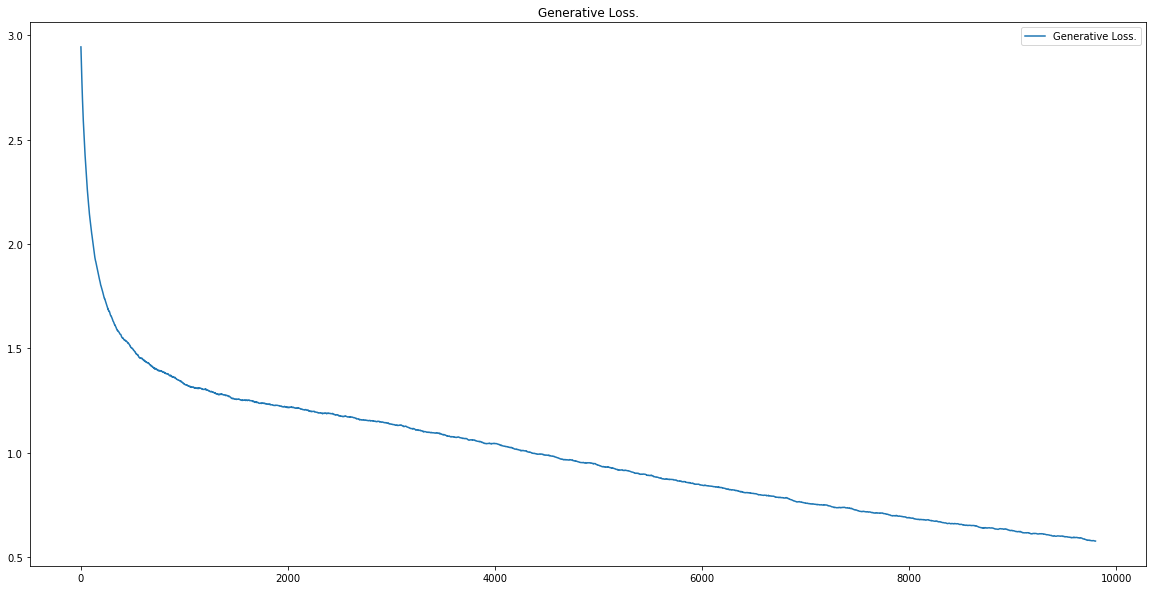

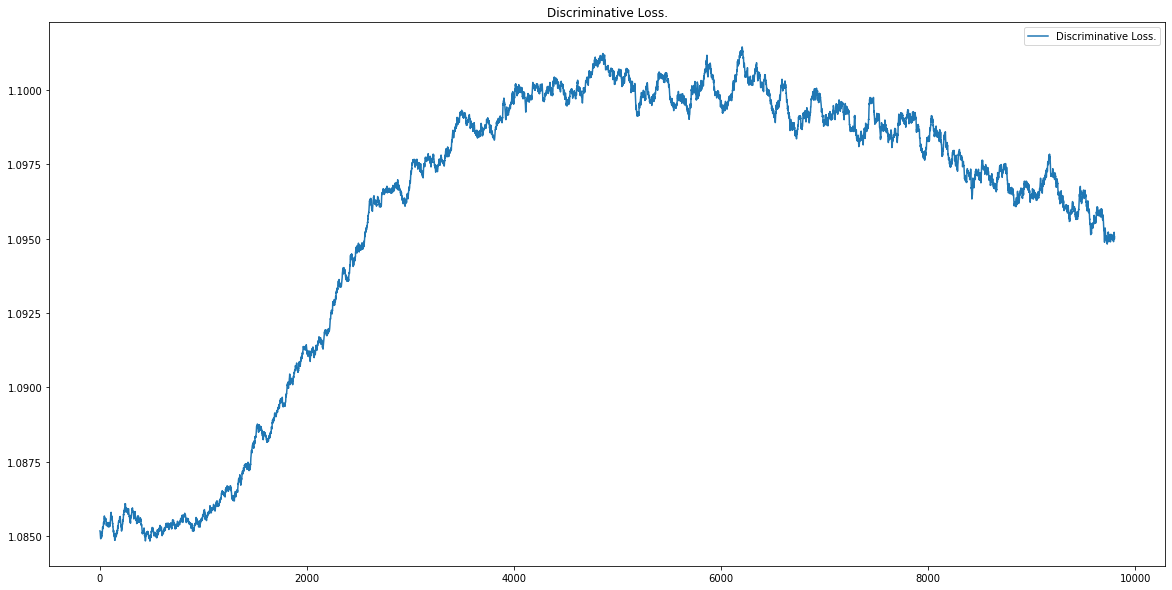

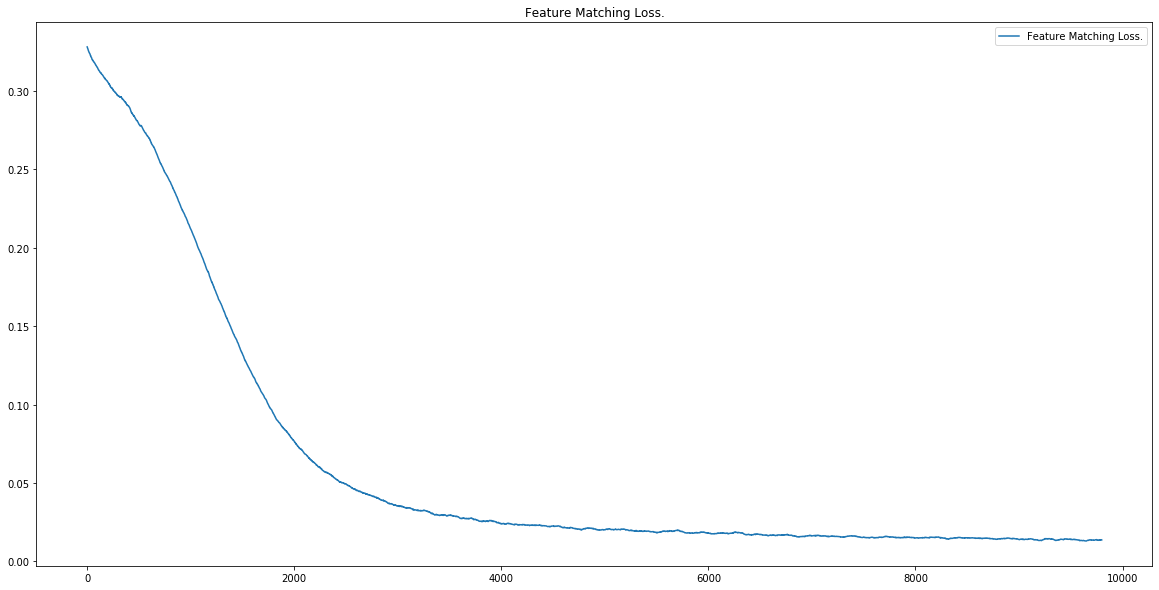

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline

def moving_avg(arr, window=100):
    return np.convolve(arr, np.ones(window) / window, mode='same')[window:-window]

plt.figure(figsize=(20, 10))
plt.plot(moving_avg(EBAAE.generative_loss_arr), label="Generative Loss.")
plt.legend()
plt.title("Generative Loss.")
plt.show()

plt.figure(figsize=(20, 10))
plt.plot(moving_avg(EBAAE.discriminative_loss_arr), label="Discriminative Loss.")
plt.legend()
plt.title("Discriminative Loss.")
plt.show()

plt.figure(figsize=(20, 10))
plt.plot(moving_avg(EBAAE.feature_matching_loss_arr), label="Feature Matching Loss.")
plt.legend()
plt.title("Feature Matching Loss.")
plt.show()


Visualize the posterior.

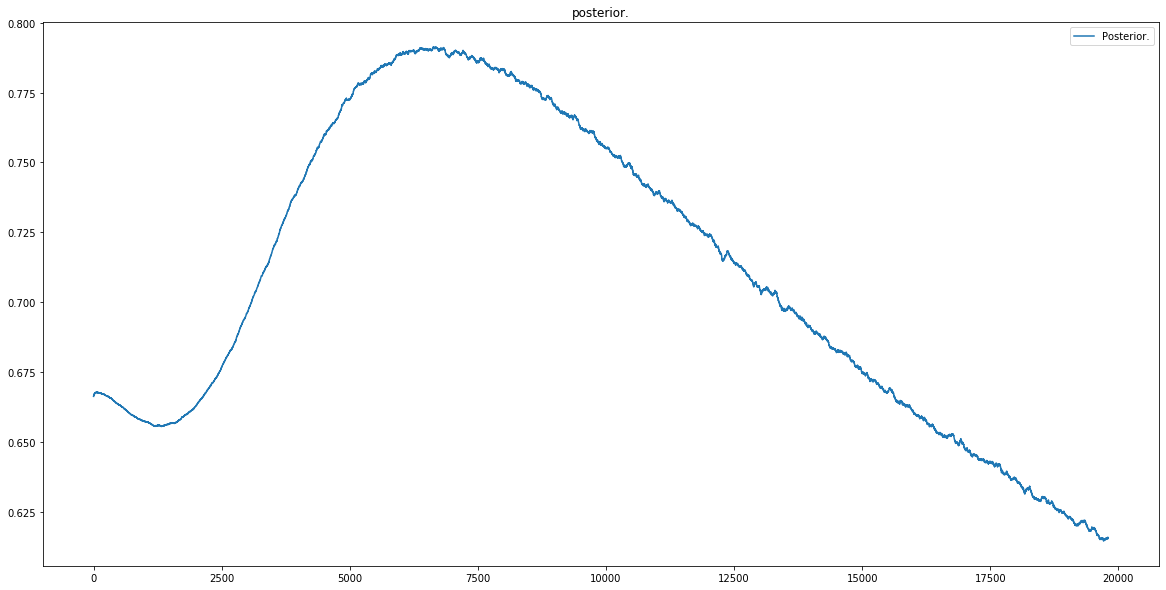

In [28]:
plt.figure(figsize=(20, 10))
plt.plot(moving_avg(EBAAE.posterior_logs_arr), label="Posterior.")
plt.legend()
plt.title("posterior.")
plt.show()

You can observe reconstructed images as follows.

Observed data.


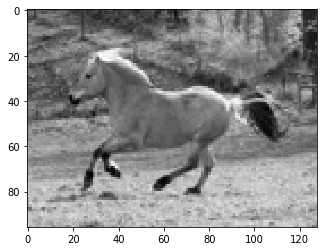

Feature points.


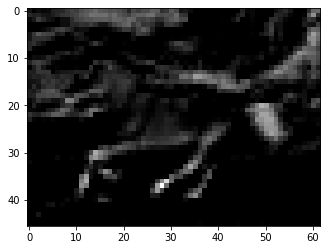

Reconstructed data.


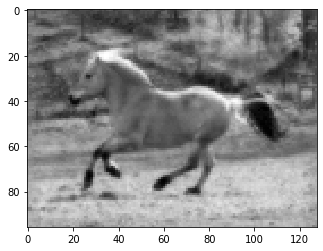

Observed data.


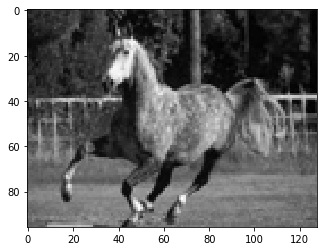

Feature points.


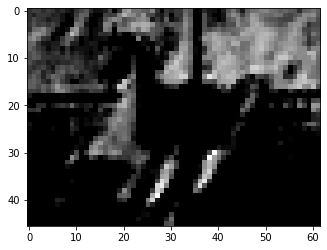

Reconstructed data.


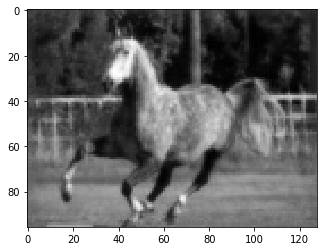

Observed data.


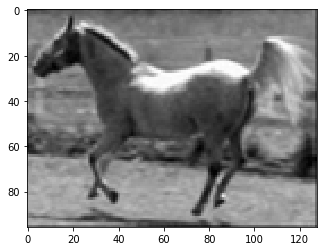

Feature points.


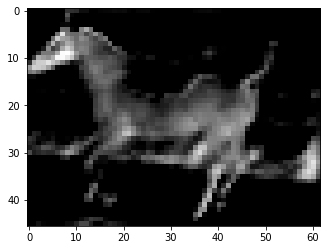

Reconstructed data.


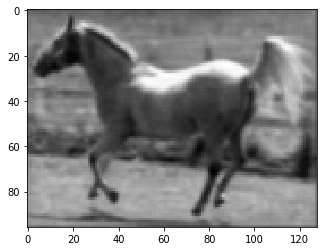

In [37]:
generated_arr, observed_arr, decoded_arr = EBAAE.generative_model.draw()

import matplotlib.pyplot as plt
%matplotlib inline

for i in range(3):
    print("Observed data.")
    plt.imshow(observed_arr[i, 0].asnumpy(), cmap="gray")
    plt.show()
    print("Feature points.")
    plt.imshow(generated_arr[i, 0].asnumpy(), cmap="gray")
    plt.show()
    print("Reconstructed data.")
    plt.imshow(decoded_arr[i, 0].asnumpy(), cmap="gray")
    plt.show()

## For ML Ops.

This model inherits [HybridBlock](https://gluon.mxnet.io/chapter07_distributed-learning/hybridize.html) from [mxnet.gluon](https://mxnet.incubator.apache.org/api/python/docs/api/gluon/index.html). Functions for common ML Ops such as saving and loading parameters are provided by [HybridBlock](https://mxnet.apache.org/api/python/docs/api/gluon/hybrid_block.html).

# References

- Gauthier, J. (2014). Conditional generative adversarial nets for convolutional face generation. Class Project for Stanford CS231N: Convolutional Neural Networks for Visual Recognition, Winter semester, 2014(5), 2.
- Goodfellow, I., Pouget-Abadie, J., Mirza, M., Xu, B., Warde-Farley, D., Ozair, S., ... & Bengio, Y. (2014). Generative adversarial nets. In Advances in neural information processing systems (pp. 2672-2680).
- Makhzani, A., Shlens, J., Jaitly, N., Goodfellow, I., & Frey, B. (2015). Adversarial autoencoders. arXiv preprint arXiv:1511.05644.
- Mirza, M., & Osindero, S. (2014). Conditional generative adversarial nets. arXiv preprint arXiv:1411.1784.
- Salimans, T., Goodfellow, I., Zaremba, W., Cheung, V., Radford, A., & Chen, X. (2016). Improved techniques for training gans. In Advances in neural information processing systems (pp. 2234-2242).
- Zhao, J., Mathieu, M., & LeCun, Y. (2016). Energy-based generative adversarial network. arXiv preprint arXiv:1609.03126.
- Warde-Farley, D., & Bengio, Y. (2016). Improving generative adversarial networks with denoising feature matching.